# EDA regarding:
* Mean number of slices per patient
* Quantitative analysis regarding tumours in 2D and 3D
* Visual comparison between train and validation
* Contributes to hyperparameter tunning for batch stack size

In the file `./eda1_computational_effort_training.pkl`, we have stored the following matrices:

- `binning_volume`: Splits the stacks into percentage bins and counts the number of tumorous slices in each volume % wise

- `stacks_full_volume`: Splits stacks one by one to MAX_SLICES slices and counts the number of tumorous voxels in each slice of the volume

- `bins_2d`: For each patient, counts the number of tumorous pixels in each 512x512 frame

- `zoomed_bins_2d`: Splits the 2D images into 16x16 patches and counts the number of tumorous pixels in each patch

- `tumor_volume`: Counts the number of tumorous voxels in each patient compared to the total number of voxels

- `slices_per_patient`: Counts the number of slices in each patient


As it takes 3 hours to generate those on the original dataset

# Install

In [1]:
# !pip install -q "monai-weekly[nibabel, skimage, scipy, pillow, tensorboard, gdown, ignite, torchvision, itk, tqdm, lmdb, psutil, cucim, openslide, pandas, einops, transformers, mlflow, clearml, matplotlib, tensorboardX, tifffile, imagecodecs, pyyaml, fire, jsonschema, ninja, pynrrd, pydicom, h5py, nni, optuna, onnx, onnxruntime, zarr, lpips, pynvml, huggingface_hub]"

# Import libraries

In [2]:
import os
import warnings
warnings.filterwarnings("ignore") # remove some scikit-image warnings

from monai.apps import DecathlonDataset
from monai.data import DataLoader
from monai.transforms import (
    LoadImageD,
    Compose,
    LoadImageD,
)

import torch
import numpy as np
import matplotlib.pyplot as plt
import random

#### Set seeds

In [3]:
import sys
from tqdm import tqdm
import pickle as pkl

In [4]:
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

### Hyperparameters

In [5]:
BATCH_SIZE = 1

IMG_HEIGHT = 128
IMG_WIDTH = 128
COLOUR_CHANNELS = 1
# NO_STACKED_IMGS = 64

In [6]:
crt_dir = os.getcwd()

datasets_path = f'{crt_dir}/datasets/MedicalDecathlon/'

# Visualize data

## TRAIN

In [7]:
# Set up transform
KEYS = ["image", "label"]

base_transform = Compose([
    LoadImageD(keys=KEYS),
])

train_transform = Compose([
    LoadImageD(keys=KEYS),    
])

In [8]:
def read_memoized_data(path, split_name):
    crt_path = f'{path}/{split_name}'
    
    no_patients = len(os.listdir(f'{crt_path}/images'))
    
    patients = []

    for patient_id in range(no_patients):
        img = torch.load(f'{crt_path}/images/patient_{patient_id}.pt')
        label = torch.load(f'{crt_path}/labels/patient_{patient_id}.pt')
        patients.append({"image": img.squeeze(0), "label": label.squeeze(0)})
    
    return patients

In [9]:
# Load dataset
memoized_path = f'/raid/CataChiru/MedicalDecathlonTensors/'
memoized_path = f'./datasets/MedicalDecathlonJustTumors/'
memoized_flag = True

name_stacks_pkl = f'{crt_dir}/tumorous_stacks_training.pkl'
knows_tumorous_stacks_for_training = os.path.exists(name_stacks_pkl)
if not os.path.exists(memoized_path) or not memoized_flag:
    if knows_tumorous_stacks_for_training:
        with open(f'{crt_dir}/tumorous_stacks_training.pkl', 'rb') as f:
            patients = pkl.load(f)


    train_name = 'training' # From Monai: ['training', 'validation', 'test']
    train_dataset = DecathlonDataset(root_dir = f'{datasets_path}{train_name}/',
                            task = "Task06_Lung", section = train_name,
                            transform = base_transform, download = False)


    if knows_tumorous_stacks_for_training:
        for i in range(len(train_dataset)):
            train_dataset[i]['image'] = train_dataset[i]['image'][:, :, patients[i]]
            train_dataset[i]['label'] = train_dataset[i]['label'][:, :, patients[i]]
else:
    print('Loading memoized data')
    train_dataset = read_memoized_data(memoized_path, 'training')
    

train_loader = DataLoader(train_dataset, batch_size = 1, shuffle = False) #, num_workers = 1)

Loading memoized data


In [10]:
train_dataset[0]['image'].shape

torch.Size([512, 512, 86])

In [11]:
slices_per_patient_tr = [patient['image'].shape[-1] for patient in train_dataset]

In [12]:
# Counts the number of slices with tumour for each patient
if not knows_tumorous_stacks_for_training:
    patients_tumour = {patient: [] for patient in range(len(train_dataset))}

    for i, data in enumerate(tqdm(train_loader)):
        label = data['label'][0]
        print(label.shape)

        for j in range(label.shape[-1]):
            if (label[:, :, j].sum() != 0):
                patients_tumour[i].append(j)

    # Memoize those slices for later use
    with open(name_stacks_pkl, 'wb') as f:
        pkl.dump(patients_tumour, f)

In [13]:
patients_tumour = pkl.load(open(name_stacks_pkl, 'rb'))

In [15]:
patients_tumour

{0: [334,
  335,
  336,
  337,
  338,
  339,
  340,
  341,
  342,
  343,
  344,
  345,
  346,
  347,
  348,
  349,
  350,
  351,
  352,
  353,
  354,
  355,
  356,
  357,
  358,
  359,
  360,
  361,
  362,
  363,
  364,
  365,
  366,
  367,
  368,
  369,
  370,
  371,
  372,
  373,
  374,
  375,
  376,
  377,
  378,
  379,
  380,
  381,
  382,
  383,
  384,
  385,
  386,
  387,
  388,
  389,
  390,
  391,
  392,
  393,
  394,
  395,
  396,
  397,
  398,
  399,
  400,
  401,
  402,
  403],
 1: [179,
  180,
  181,
  182,
  183,
  184,
  185,
  186,
  187,
  188,
  189,
  190,
  191,
  192,
  193,
  194,
  195,
  196,
  197,
  198,
  199,
  200,
  201,
  202,
  203,
  204,
  205,
  206,
  207,
  208,
  209,
  210,
  211,
  212,
  213,
  214,
  215,
  216,
  217,
  218,
  219],
 2: [155,
  156,
  157,
  158,
  159,
  160,
  161,
  162,
  163,
  164,
  165,
  166,
  167,
  168,
  169,
  170,
  171,
  172,
  173,
  174,
  175,
  176,
  177,
  178,
  179,
  180,
  181,
  182,
  183,
  184,
  

In [115]:
# Overall there are around 900 stacks with tumour volume > 0.125
# We want besides the tumour volume to keep 8 slices before and 8 slices after the tumour volume or 16 slices in total, if patient's last slices are tumorous
def get_tumorous_stacks(train_dataset, patients_tumour : {int : [int]}, no_padding_stacks : int = 16) -> {int : {str : int}}:
    '''
    From the strictly tumorous slices, adds a padding buffer zone of no_padding_stacks // 2 slices before and after the tumorous slices
    If the tumorous slices are at the beginning or end of the patient's slices, the padding buffer zone is added at the opposite end

    :param train_dataset: the dataset with the patients' images, needed to know the number of slices for each patient
    :param patients_tumour: a dictionary with the patients' tumorous slices as a list of indices
    :param no_padding_stacks: the total number of slices to pad for each patient
    
    :return: a dictionary of type {patient_id : {start : int, stop : int}}
    '''
    tumorous_stacks = {}

    half_padding = no_padding_stacks // 2

    for i, patient in enumerate(train_dataset):
        
        tumorous_slices = patients_tumour[i]

        min_slice, max_slice = min(tumorous_slices), max(tumorous_slices)


        if min_slice - half_padding < 0:
            min_slice = 0
            max_slice = max_slice + no_padding_stacks + (half_padding - min_slice)
        else:
            min_slice = min_slice - half_padding

        if max_slice + half_padding >= patient['image'].shape[-1]:
            max_slice = patient['image'].shape[-1] - 1
            min_slice = min_slice - no_padding_stacks - (half_padding - (patient['image'].shape[-1] - max_slice - 1))
        else:
            max_slice = max_slice + half_padding



        tumorous_stacks[i] = {'start': min_slice, 'stop': max_slice}

    return tumorous_stacks

In [116]:
get_tumorous_stacks(train_dataset, patients_tumour)

{0: {'start': 326, 'stop': 411},
 1: {'start': 171, 'stop': 227},
 2: {'start': 147, 'stop': 193},
 3: {'start': 303, 'stop': 335},
 4: {'start': 141, 'stop': 167},
 5: {'start': 131, 'stop': 188},
 6: {'start': 71, 'stop': 95},
 7: {'start': 164, 'stop': 192},
 8: {'start': 145, 'stop': 180},
 9: {'start': 513, 'stop': 549},
 10: {'start': 197, 'stop': 272},
 11: {'start': 223, 'stop': 258},
 12: {'start': 59, 'stop': 83},
 13: {'start': 59, 'stop': 99},
 14: {'start': 178, 'stop': 207},
 15: {'start': 141, 'stop': 172},
 16: {'start': 127, 'stop': 177},
 17: {'start': 192, 'stop': 221},
 18: {'start': 209, 'stop': 239},
 19: {'start': 152, 'stop': 194},
 20: {'start': 439, 'stop': 494},
 21: {'start': 291, 'stop': 341},
 22: {'start': 136, 'stop': 180},
 23: {'start': 137, 'stop': 169},
 24: {'start': 84, 'stop': 112},
 25: {'start': 82, 'stop': 109},
 26: {'start': 79, 'stop': 126},
 27: {'start': 208, 'stop': 293},
 28: {'start': 137, 'stop': 173},
 29: {'start': 120, 'stop': 149},

In [102]:
# from copy import deepcopy

# # Reduce the dataset to only the relevant slices per patient
# only_tumours_dataset = deepcopy(train_dataset)

# for i in range(len(only_tumours_dataset)):
#     only_tumours_dataset[i]['label'] = only_tumours_dataset[i]['label'][:, :, patients[i]]

# only_tumours_loader = DataLoader(only_tumours_dataset, batch_size = BATCH_SIZE, shuffle = False) #, num_workers = 1)

In [103]:
def get_EDA_params(dataset, crt_loader):
    ''' Returns from the dataset:
        - Number of patients
        - Max number of stacks
        - Image height
        - Image width
    '''


    print("Getting EDA parameters...")
    NO_PATIENTS = len(dataset)
    print(f'Number of patients: {NO_PATIENTS}')

    NO_STACKS = -1
    IMG_HEIGHT = -1
    IMG_WIDTH = -1
    for patient_batch in tqdm(crt_loader):
        # print(patient_batch['image'].shape)
        NO_STACKS = max(NO_STACKS, patient_batch['image'].shape[-1])
        IMG_HEIGHT = patient_batch['image'].shape[1]
        IMG_WIDTH = patient_batch['image'].shape[2]
        # break

    print(f'Number of max-stacks: {NO_STACKS}')
    print(f'Image height: {IMG_HEIGHT}')
    print(f'Image width: {IMG_WIDTH}')

    return NO_PATIENTS, NO_STACKS, IMG_HEIGHT, IMG_WIDTH


In [104]:
NO_PATIENTS_TR, NO_STACKS_TR, IMG_HEIGHT_TR, IMG_WIDTH_TR = get_EDA_params(train_dataset, train_loader)

Getting EDA parameters...
Number of patients: 51


100%|██████████| 51/51 [00:03<00:00, 14.82it/s]

Number of max-stacks: 636
Image height: 512
Image width: 512


In [105]:
train_dataset[0]['image'][0, ...,0].shape

torch.Size([512])

TypeError: Invalid shape (512,) for image data

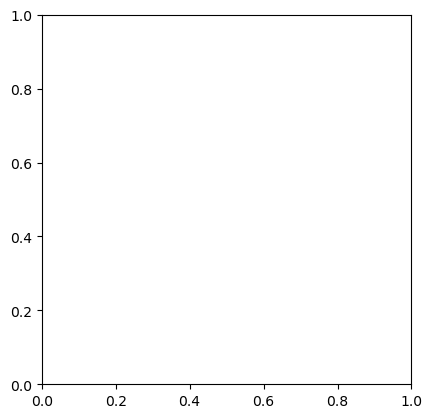

In [106]:
a =train_dataset[0]['image'][0, ...,5].numpy()
plt.imshow(a, cmap='gray')
plt.gca().invert_yaxis()
plt.gca().axis('off')
plt.show()

In [ ]:
def show_slices(crt_loader):
    ''' Plots consecutively the first slice of the stack for all the patients in the loader '''
    for patient_batch in tqdm(crt_loader):
        img = patient_batch['image'][0].numpy()
        label = patient_batch['label'][0].numpy()

        plt.imshow(img[:, :, 0], cmap='gray')
        plt.imshow(label[:, :, 0], cmap='jet', alpha=0.5)
        plt.gca().invert_yaxis()
        plt.gca().axis('off')
        plt.show()

In [ ]:
print_slices_flag = False
if print_slices_flag:
    show_slices(train_loader)

In [ ]:
def instantiate_quantitative_counters(NO_PATIENTS, NO_STACKS, IMG_HEIGHT, IMG_WIDTH):
    '''
    Instatiates the following matrices for EDA:

    - binning_volume: Splits the stacks into percentage bins and counts the number of tumorous slices in each volume % wise

    - stacks_full_volume: Splits stacks one by one to MAX_SLICES slices and counts the number of tumorous voxels in each slice of the volume

    - bins_2d: For each patient, counts the number of tumorous pixels in each 512x512 frame

    - zoomed_bins_2d: Splits the 2D images into 16x16 patches and counts the number of tumorous pixels in each patch

    - tumor_volume: Counts the number of tumorous voxels in each patient compared to the total number of voxels

    - slices_per_patient: Counts the number of slices in each patient

    '''
    
    # Splits the stacks into percentage bins and counts the number of tumor slices in each bin
    binning_volume = np.zeros((NO_PATIENTS, 10))

    # Splits stacks one by one to MAX_SLICES slices and counts the number of tumor slices in each patient
    stacks_full_volume = np.zeros((NO_PATIENTS, NO_STACKS))


    # Splits the 2D images into 16x16 patches and counts the number of tumor patches in each patch
    patches_height = IMG_HEIGHT // 16
    patches_width = IMG_WIDTH // 16
    bins_2d = np.zeros((NO_PATIENTS, IMG_HEIGHT, IMG_WIDTH))
    zoomed_bins_2d = np.zeros((NO_PATIENTS, patches_height, patches_width))

    # Counts the number of tumor voxels in each patient
    tumor_volume = np.zeros((NO_PATIENTS, 2)) # On first column tumor volume, on second column total volume
    slices_per_patient = np.zeros(NO_PATIENTS)

    return binning_volume, stacks_full_volume, bins_2d, zoomed_bins_2d, patches_height, patches_width, tumor_volume, slices_per_patient


def update_quantitative_counters(dataset, crt_loader):
    '''
    In one pass of the loader, updates the matrices for EDA:

    - binning_volume: Counts the number of tumorous slices in each volume % wise

    - stacks_full_volume: Counts the number of tumorous voxels in each slice of the volume

    - bins_2d: For each patient, counts the number of tumorous pixels in each 512x512 frame

    - zoomed_bins_2d: Splits the 2D images into 16x16 patches and counts the number of tumorous pixels in each patch

    - tumor_volume: Counts the number of tumorous voxels in each patient compared to the total number of voxels

    - slices_per_patient: Counts the number of slices in each patient

    '''

    NO_PATIENTS, NO_STACKS, IMG_HEIGHT, IMG_WIDTH = get_EDA_params(dataset, crt_loader)

    binning_volume, stacks_full_volume, bins_2d, zoomed_bins_2d, patches_height, patches_width, tumor_volume, slices_per_patient = instantiate_quantitative_counters(NO_PATIENTS, NO_STACKS, IMG_HEIGHT, IMG_WIDTH)

    print(f"zoomed 2D bins shape: {zoomed_bins_2d.shape} (NO_PATIENTS, NO_PATCHES_HEIGHT, NO_PATCHES_WIDTH)")
    print(f"2D bins shape: {bins_2d.shape} (NO_PATIENTS, IMG_HEIGHT, IMG_WIDTH)")

    print(f"Depth bins shape: {binning_volume.shape} (NO_PATIENTS, PERCENTAGE_BINS)")

    i = 0
    for patient_batch in tqdm(crt_loader):
        label = patient_batch["label"][0].numpy()
        # print(label.shape)

        slices_per_patient[i] = label.shape[-1]

        crt_bin = zoomed_bins_2d[i]

        for j in range(label.shape[-1]):
            crt_stack = label[:, :, j]

            if np.sum(crt_stack) != 0:
                idx = int(((j * 10) / label.shape[-1]))
                binning_volume[i, idx] += 1
                stacks_full_volume[i, j] += 1

            for x in range(patches_height):
                for y in range(patches_width):
                    margins_height = (x+1)*16 if (x+1)*16 < IMG_HEIGHT else IMG_HEIGHT
                    margins_width = (y+1)*16 if (y+1)*16 < IMG_WIDTH else IMG_WIDTH

                    if np.sum(crt_stack[x*16:margins_height, y*16:margins_width]) != 0:
                        crt_bin[x, y] += 1

            for x in range(IMG_HEIGHT):
                for y in range(IMG_WIDTH):
                    if crt_stack[x, y] != 0:
                        bins_2d[i, x, y] += 1


        tumor_volume[i] = np.array([np.count_nonzero(label), IMG_HEIGHT*IMG_WIDTH*label.shape[-1]])
                
        i += 1


    return binning_volume, stacks_full_volume, bins_2d, zoomed_bins_2d, tumor_volume, slices_per_patient

In [ ]:
computational_effort_train_path = f'./msd_eda1_computational_effort_{train_name}.pkl'

In [ ]:
if not os.path.exists(computational_effort_train_path):
    binning_volume_tr, stacks_full_volume_tr, bins_2d_tr, zoomed_bins_2d_tr, tumor_volume_tr, slices_per_patient_tr = update_quantitative_counters(train_dataset, train_loader)
    with open(computational_effort_train_path, 'wb') as f:
        pkl.dump([binning_volume_tr, stacks_full_volume_tr, bins_2d_tr, zoomed_bins_2d_tr, tumor_volume_tr, slices_per_patient_tr], f)
else:
    print("Computatinal effort file already exists. Loading it...")
    binning_volume_tr, stacks_full_volume_tr, bins_2d_tr, zoomed_bins_2d_tr, tumor_volume_tr, slices_per_patient_tr = pkl.load(open(computational_effort_train_path, 'rb'))

Computatinal effort file already exists. Loading it...


In [ ]:
def plots_bar_hist_interface(counts_list, split_name, counts_name, verbose_flag = False):
    '''
    Interface function used for quantitative measures on slices per patient or tumorous slices per patient

    1 x 2 grid of plots:
    - Barplot: Number of quantity in CT for each patient based on patients ID
    - Histogram: Count of patients with at least determined quantity in CT
    '''

    NO_PATIENTS = len(counts_list)
    mean_counts = np.mean(counts_list)
    std_counts = np.std(counts_list)

    print(f'Mean number of {counts_name}: {mean_counts}')
    print(f'Std for the number of {counts_name}: {std_counts}')

    fig, ax = plt.subplots(1,2, figsize=(15, 5))

    # Slices
    ax[0].bar(range(NO_PATIENTS), counts_list)

    # Add the number of slices as text on top of each bar
    if verbose_flag:
        for i in range(NO_PATIENTS):
            ax[0].text(i, counts_list[i], f'{counts_list[i]}', ha='center')

    # Add the mean as a red line, starting from 0 to NO_PATIENTS
    ax[0].axhline(mean_counts, color='red', label='Mean')

    # Add variance as a yellow faded area
    ax[0].fill_between(np.arange(-0.5, NO_PATIENTS+0.5), mean_counts - std_counts, mean_counts + std_counts, color='yellow', alpha=0.5, label='Variance')

    ax[0].set_xlim(-1, NO_PATIENTS)
    ax[0].set_xlabel('Patient')
    ax[0].set_ylabel(f'Number of {counts_name} in CT')
    ax[0].set_title(f'{split_name.capitalize()}: Number of {counts_name} in CT for each patient')
    ax[0].legend()

    # Slices
    plt.hist(counts_list, bins=10)

    # Add the mean as a red line
    ax[1].set_xlabel(f'Number of {counts_name} in CT')
    ax[1].set_ylabel(f'Number of patients with {counts_name} in CT')
    ax[1].set_title(f'{train_name.capitalize()}: Number of {counts_name} in CT for each patient - Histogram')
    fig.show()
    plt.show()

    return mean_counts, std_counts


def plots_slices_per_patient_split(slices_per_patient, split_name, verbose_flag = False):
    '''
    1 x 2 grid of plots:
    - Barplot: Number of slices in CT for each patient based on patients ID
    - Histogram: Count of patients with at least number of slices in CT
    '''

    return plots_bar_hist_interface(slices_per_patient, split_name, 'slices', verbose_flag)


def plots_tumor_slices_per_patient_split(stacks_full_volume, split_name, verbose_flag = False):
    '''
    1 x 2 grid of plots:
    - Barplot: Number of tumorous stacks in CT for each patient based on patients ID
    - Histogram: Count of patients with at least number of tumorous stacks in CT
    '''

    return plots_bar_hist_interface(stacks_full_volume, split_name, 'tumorous stacks', verbose_flag)

Mean number of slices: 230.8235294117647
Std for the number of slices: 75.45124536254481


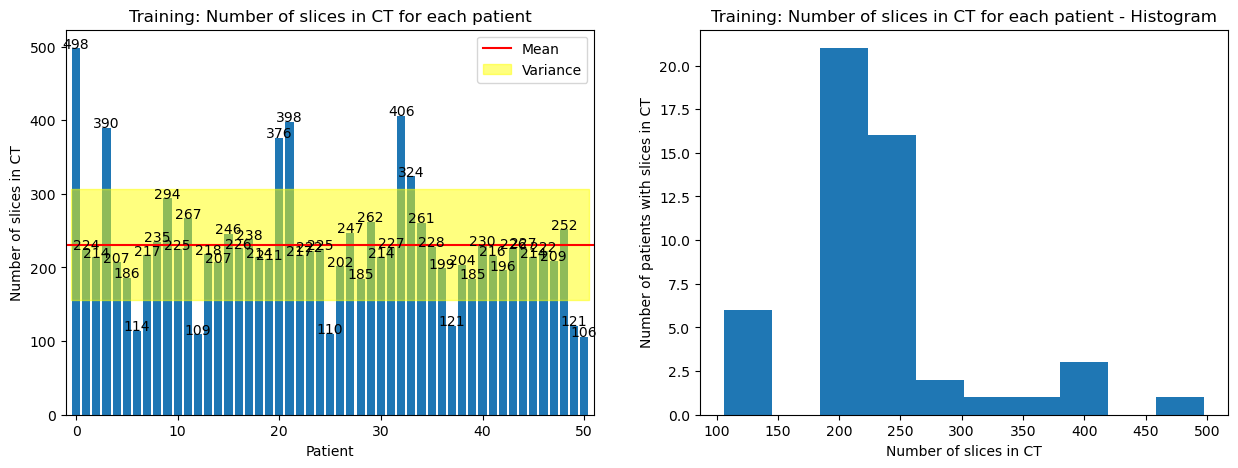

(230.8235294117647, 75.45124536254481)

In [ ]:
plots_slices_per_patient_split(slices_per_patient_tr, train_name, verbose_flag = True)

In [ ]:
# Compute the 2D bounding box for the aggregated tumour from all the training patients

aggregative_2d_tumor = np.sum(bins_2d_tr, axis=0)
height, width = aggregative_2d_tumor.shape

h_min, h_max = -1, -1
w_min, w_max = -1, -1

for i in range(height):
    if np.sum(aggregative_2d_tumor[i, :]) != 0:
        h_min = i
        break

for i in range(height-1, 0, -1):
    if np.sum(aggregative_2d_tumor[i, :]) != 0:
        h_max = i
        break

for i in range(width):
    if np.sum(aggregative_2d_tumor[:, i]) != 0:
        w_min = i
        break

for i in range(width-1, 0, -1):
    if np.sum(aggregative_2d_tumor[:, i]) != 0:
        w_max = i
        break

print(f'Bounding box for tumor in 2D: (Hmin: {h_min}, Hmax: {h_max}), (Wmin: {w_min}, Wmax: {w_max})')

bbox_2d = (h_min, h_max, w_min, w_max)

In [ ]:
def plot_patients_heatmaps(bins_2d, name, bbox_flag = False, bbox = None):
    '''
    Plots the heatmaps of the tumorous pixels for each patient in the dataset, bordered by the bounding box if bbox_flag is True

    Can be used for the matrices: bins_2d or zoomed_bins_2d
    '''

    NO_PATIENTS = len(bins_2d)
    #  Create heatmap for each patient
    for i in range(NO_PATIENTS):
        plt.title(f'{name.capitalize()}: Patient {i}')
        plt.imshow(bins_2d[i], cmap='hot')

        if bbox_flag:
            h_min, h_max, w_min, w_max = bbox
            plt.gca().add_patch(plt.Rectangle((w_min, h_min), w_max - w_min, h_max - h_min, fill=False, edgecolor='blue', lw=2))
        plt.gca().invert_yaxis()
        plt.show()

In [ ]:
if print_slices_flag:
    plot_patients_heatmaps(bins_2d_tr, train_name, bbox_flag = True, bbox = bbox_2d)

In [ ]:
def plot_aggregative_heatmaps(bins, binning_volume, name, bbox_flag = False, bbox = None):
    '''
    1 x 2 grid of plots:
    - Plots the heatmap of the tumorous 2D slices for all the patients in the dataset split aggregated in one frame.
        Can be used for the matrices: bins_2d or zoomed_bins_2d
        
    - Plots the volume distribution of the tumorous slices for all the patients in the dataset split
    '''

    NO_PATIENTS = len(bins)
    fig, ax = plt.subplots(1,2, figsize=(20, 5))

    ax[0].set_title(f'{train_name.capitalize()}: Patients\' cummulative tumours in 2D')
    img0 = ax[0].imshow(np.sum(bins, axis=0), cmap='hot')

    if bbox_flag:
        h_min, h_max, w_min, w_max = bbox
        ax[0].add_patch(plt.Rectangle((w_min, h_min), w_max - w_min, h_max - h_min, fill=False, edgecolor='blue', lw=2))

    # Make colorbar the same size as the image
    plt.colorbar(img0, ax=ax[0], pad = 0.005)
    ax[0].invert_yaxis()
    ax[0].set_xlabel('Patch width')
    ax[0].set_ylabel('Patch height')
    ax[0].axis('off')
    # ax[0].axis('tight')
    # ax[0].show()
    # fig.show()
    
    # Diminish space between plots
    plt.subplots_adjust(wspace=-0.075)
    
    # Make ax[1] bigger on x-axis
    ax[1].figure.set_size_inches(50, 5, forward=True)

    ax[1].set_title(f'{name.capitalize()}: Patients volume tumour distribution')
    # Make the cells bigger
    im1 = ax[1].imshow(binning_volume.T, cmap='hot', aspect='auto', interpolation='nearest')

    # Move the colorbar closer to its heatmap
    plt.colorbar(im1, ax=ax[1], pad=0.005) #fraction=0.046, 

    yticks=range(10)
    # Make y start from 0
    ax[1].invert_yaxis()
    ax[1].set_xticks(range(NO_PATIENTS))
    ax[1].set_yticks(yticks)
    ax[1].axis('tight')
    ax[1].set_xlabel('Patient')
    ax[1].set_ylabel('Tumour found in volume (%)')

    fig.show()
    plt.show()

In [ ]:
plot_aggregative_heatmaps(bins_2d_tr, binning_volume_tr, train_name, bbox_flag=True, bbox=bbox_2d)

In [ ]:
plt.title(f'{train_name.capitalize()}: Bounded Aggregative tumour in 2D')
plt.imshow(aggregative_2d_tumor[h_min:h_max, w_min:w_max], cmap='hot')
plt.gca().invert_yaxis()
plt.gca().axis('off')

In [ ]:
mean_tumor_stacks_tr, std_tumor_stacks_tr = plots_tumor_slices_per_patient_split(np.sum(stacks_full_volume_tr, axis=1), train_name, verbose_flag = True)

In [ ]:
import pandas as pd

df = pd.DataFrame(tumor_volume_tr, columns=['Tumor Volume (Voxels)', 'Total Volume (Voxels)'])

# Name index column "Patient"
df.index.name = 'Patient'

df['Tumor Volume (%)'] = df['Tumor Volume (Voxels)'] / df['Total Volume (Voxels)'] * 100

df.to_csv('tumor_volume.csv')

In [ ]:
df

In [ ]:
tumor_sizes = np.sum(stacks_full_volume_tr, axis=1)
np.min(tumor_sizes), np.max(tumor_sizes), np.mean(tumor_sizes), np.std(tumor_sizes)

## VALIDATION

In [ ]:
# Load dataset
val_name = 'validation'
if not os.path.exists(memoized_path) or not memoized_flag:
    val_dataset = DecathlonDataset(root_dir = f'{datasets_path}{val_name}/',
                            task = "Task06_Lung", section = val_name,
                            transform = train_transform, download = False)
else:
    val_dataset = read_memoized_data(memoized_path, 'validation')
    

val_loader = DataLoader(val_dataset, batch_size = BATCH_SIZE, shuffle = False) #, num_workers = 1)

In [ ]:
NO_PATIENTS_VAL, NO_STACKS_VAL, IMG_HEIGHT_VAL, IMG_WIDTH_VAL = get_EDA_params(val_dataset, val_loader)

In [ ]:
print_slices_flag = False
if print_slices_flag:
    show_slices(val_loader)

In [ ]:
computational_effort_val_path = f'./msd_eda1_computational_effort_{val_name}.pkl'

if not os.path.exists(computational_effort_val_path):
    binning_volume_val, stacks_full_volume_val, bins_2d_val, zoomed_bins_2d_val, tumor_volume_val, slices_per_patient_val  = update_quantitative_counters(val_dataset, val_loader)
    with open(computational_effort_val_path, 'wb') as f:
        pkl.dump([binning_volume_val, stacks_full_volume_val, bins_2d_val, zoomed_bins_2d_val, tumor_volume_val, slices_per_patient_val], f)
else:
    print("Computatinal effort file already exists. Loading it...")
    binning_volume_val, stacks_full_volume_val, bins_2d_val, zoomed_bins_2d_val, tumor_volume_val, slices_per_patient_val = pkl.load(open(computational_effort_train_path, 'rb'))

In [ ]:
plots_slices_per_patient_split(slices_per_patient_val, val_name, verbose_flag = True)

In [ ]:
plot_patients_heatmaps(bins_2d_val, val_name) #bbox_flag = True, bbox = bbox_2d)

In [ ]:
plot_aggregative_heatmaps(bins_2d_val, binning_volume_val, val_name, bbox_flag=True, bbox=bbox_2d)

In [ ]:
mean_tumor_stacks_val, std_tumor_stacks_val = plots_tumor_slices_per_patient_split(np.sum(stacks_full_volume_val, axis=1), val_name)

In [ ]:
tumor_sizes_val = np.sum(stacks_full_volume_val, axis=1)
np.min(tumor_sizes_val), np.max(tumor_sizes_val), np.mean(tumor_sizes_val), np.std(tumor_sizes_val)

In [ ]:
tumor_sizes_filtered = np.array([x for x in tumor_sizes_val if x >= mean_tumor_stacks_val - std_tumor_stacks_val and x <= mean_tumor_stacks_val + std_tumor_stacks_val])
len(tumor_sizes_filtered)

In [ ]:
# Iteratively remove the outliers, until the mean and std stabilize
# Used as a coarse method for establishing an upper bound for the number of tumorous stacks
mean_tumor_stacks_tr2, std_tumor_stacks_tr2 = plots_tumor_slices_per_patient_split(tumor_sizes_filtered, train_name)
tumor_sizes_filtered = np.array([x for x in tumor_sizes_filtered if x >= mean_tumor_stacks_tr2 - std_tumor_stacks_tr2 and x <= mean_tumor_stacks_tr2 + std_tumor_stacks_tr2])